In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

# Intersection of a line and a capsule

Source material:
 - [Line-sphere intersection](https://en.wikipedia.org/wiki/Line%E2%80%93sphere_intersection)
 - [Equation of a capsule](https://math.stackexchange.com/questions/1609139/equation-of-a-spherocylinder-capsule/1609153#1609153)
 - [Algorithm for intersection of a line and a capsule](https://stackoverflow.com/questions/52460308/capsule-ray-line-segment-intersection-2d/52462458#52462458)
 
 
## Analytical solution method:
 1.  Input this into wolfram alpha: `solve for l in (l*x -b)^2 + (l*y-c)^2 + 0.25*(|l*z - d - a| + |l*z - d + a| -2*a^2) = r^2`. `b`, `c` and `d` are the location of the capsule centroid.
 2. Get a few solutions back that correspond to analytic expressions for the intersection. This assumes that the axis of the cylinder is in the z direction, so would need to implement a coordinate change to get the ray in the right reference frame (**NOTE THAT ABOVE SOLUTION ASSUMES THAT THE RAY ORIGINATES AT THE ORIGIN, WHICH WONT BE TRUE ANY MORE**)
 
## Brute force method
This is what is described in the third link above
 1.  Check for intersection with the cylinder
 2.  Check for intersection with each of the caps
 3.  Work out what kind of ray it therefore must be
 4.  Calculate the intersection length

# Working attempt
 1.  Transform our ray to be in the frame of reference of the cylinder (aligned along the `z`-axis)
 1.  Check for intersection with the cylinder at ANY `z`
 2.  Find `z` of the intersection
   1.  If in the cylindrical part of the capsule, we have the answer
   2.  If in the sphere part, do a collision check with a sphere at `z=+/-a/2` as appropriate

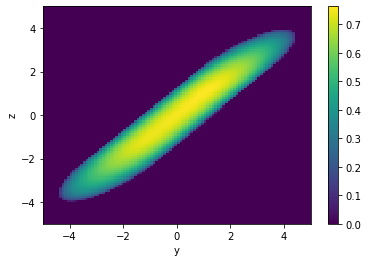

In [29]:
def get_path_length(ray_vector,ray_source,axis_length,radius):
    path_length = 0

    mag = np.linalg.norm(ray_vector)
    ray_unit_vector = ray_vector/mag

    # check for intersection with cylinder at ANY LOCAL z, i.e. does it cross a circle
    a = ray_unit_vector[0]**2 + ray_unit_vector[1]**2
    b = 2*ray_unit_vector[0]*ray_source[0] + 2*ray_unit_vector[1]*ray_source[1]
    c = ray_source[0]**2 + ray_source[1]**2 - radius**2

    discriminant_squared = b**2 - 4*a*c
    if discriminant_squared > 0: # two solutions
        l_0 = (-b + np.sqrt(discriminant_squared))/2/a
        l_1 = (-b - np.sqrt(discriminant_squared))/2/a
        l_2, x_0_good = get_collision(l_0, ray_unit_vector, ray_source, radius, axis_length,  1)
        l_3, x_1_good = get_collision(l_1, ray_unit_vector, ray_source, radius, axis_length, -1)

        if x_0_good and x_1_good:
            path_length = l_2 - l_3

    return path_length

def get_collision(l, u_hat, o, r, a, sign):
    z = o[2] + u_hat[2]*l # z position at intercept with cylinder
    if np.abs(z) < a/2: return [l, True] # inside the cylindrical part
        
    if ( z > 0 ): z_offset = a/2 # pick one sphere to check
    else: z_offset = -a/2
    c = np.array([0,0,z_offset]) # centre of sphere
    det = np.dot(u_hat, o - c)**2 - (np.linalg.norm(o - c)**2 - r**2)
    if det > 0: # if the ray collides with the sphere
        l = -np.dot(u_hat, o-c) + sign*np.sqrt(det) # pick the correct part of the sphere
        return [l, True]
    return [None, False] # nothing found

# particle properties
radius = 1
axis_length = 1
location = np.array([90,0,0]) # particle of location in global coordinates
velocity = np.array([1,1,1]) # velocity in global coordinates
dt = 2

# derived geometry stuff
axis_length = np.linalg.norm(velocity)*dt
z_unit_vector = velocity / axis_length
y_vector = np.cross(z_unit_vector, z_unit_vector*np.random.rand(1,3))
x_vector = np.cross(y_unit_vector, z_unit_vector)
A = np.vstack([x_vector/np.linalg.norm(x_vector), y_vector/np.linalg.norm(y_vector), z_unit_vector]) # rotation matrix
ray_source_rotated = np.dot(A,-location)

# detector properties
ny = 100
nz = 101
Ly = 10 # width of panel
Lz = 10 # height of panel
dy = Ly/ny
dz = Lz/nz

SDD = 100 # distance from source to detector

im = np.zeros([ny,nz])

V_sphere = 4/3*np.pi*radius**3
V_cap    = 4/3*np.pi*radius**3 + np.pi*radius**2*axis_length
path_reduction_factor = V_sphere/V_cap

with np.errstate(invalid='ignore'):
    for i in range(ny):
        y = -Ly/2 + i*dy
        for j in range(nz):
            z = -Lz/2 + j*dz

            ray_vector = np.array([SDD,y,z])
            rotated_vector = np.dot(A,ray_vector)

            path_length = get_path_length(rotated_vector,ray_source_rotated,axis_length,radius)
            im[i,j] = path_length*path_reduction_factor

plt.pcolormesh(np.linspace(-Ly/2,Ly/2,ny+1),np.linspace(-Lz/2,Lz/2,nz+1),im.T)
plt.xlabel('y')
plt.ylabel('z')
plt.colorbar()
plt.show()

In [3]:
def Delta(u_hat,x_p,r,t):
    i,j,k = u_hat
    a,b,c = x_p
    return 0.5*((c+((a*i+b*j)*k)/(-1+k**2)+x)*np.sqrt(-a**2-b**2+r**2+a**2*i**2+2*a*b*i*j+b**2*j**2+2*a*i*k*(c+t)+2*b*j*k*(c+t)-(c+t)**2+k**2*(c+t)**2)+(1/((1-k**2)**(3/2)))) 

# particle properties
radius = 1
axis_length = 1
location = np.array([90,0,0]) # particle of location in global coordinates
velocity = np.array([1,1,1]) # velocity in global coordinates
dt = 2

# derived geometry stuff
axis_length = np.linalg.norm(velocity)*dt
z_unit_vector = velocity / axis_length
y_vector = np.cross(z_unit_vector, z_unit_vector*np.random.rand(1,3))
x_vector = np.cross(y_unit_vector, z_unit_vector)
A = np.vstack([x_vector/np.linalg.norm(x_vector), y_vector/np.linalg.norm(y_vector), z_unit_vector]) # rotation matrix
ray_source_rotated = np.dot(A,-location)

# detector properties
ny = 100
nz = 101
Ly = 10 # width of panel
Lz = 10 # height of panel
dy = Ly/ny
dz = Lz/nz

SDD = 100 # distance from source to detector

im = np.zeros([ny,nz])

V_sphere = 4/3*np.pi*radius**3
V_cap    = 4/3*np.pi*radius**3 + np.pi*radius**2*axis_length
path_reduction_factor = V_sphere/V_cap

with np.errstate(invalid='ignore'):
    for i in range(ny):
        y = -Ly/2 + i*dy
        for j in range(nz):
            z = -Lz/2 + j*dz

            ray_vector = np.array([SDD,y,z])
            u = ray_vector/np.linalg.norm(ray_vector)

            
            im[i,j] = Delta(u_hat,x_p,r,0.5) - Delta(u_hat,x_p,r,-0.5)

plt.pcolormesh(np.linspace(-Ly/2,Ly/2,ny+1),np.linspace(-Lz/2,Lz/2,nz+1),im.T)
plt.xlabel('y')
plt.ylabel('z')
plt.colorbar()
plt.show()

NameError: name 'y_unit_vector' is not defined